In [1]:
import torch
import time
import os
import copy

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from skimage import io, img_as_float




print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.10.0+cu102


In [2]:
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [3]:
# !unzip hymenoptera_data.zip -d ./data/

In [4]:
data_dir = "./data/hymenoptera_data/"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

In [5]:
def get_all_filepaths(directory):
    ants_directory = os.path.join(directory, "ants")
    bees_directory = os.path.join(directory, "bees")
    
    ants_images_filepaths = sorted([os.path.join(ants_directory, f) for f in os.listdir(ants_directory)])
    bees_images_filepaths = sorted([os.path.join(bees_directory, f) for f in os.listdir(bees_directory)])
    
    return [
        *ants_images_filepaths, *bees_images_filepaths
    ]

In [6]:
train_filepaths = get_all_filepaths(train_dir)
val_filepaths = get_all_filepaths(val_dir)

In [7]:
class DataGenerator(Dataset):
    def __init__(self,
                 images_filepaths,
                 transform=None
                ):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = img_as_float(io.imread(image_filepath)).astype(np.float32)[..., :3]
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "ants":
            label = 1
        else:
            label = 0
        if self.transform is not None:
             return self.transform(image=image)["image"].float(), label
        return torch.tensor(np.moveaxis(image, 2, 0)).float(), label

In [8]:
dataset = DataGenerator(train_filepaths)

In [9]:
def visualise(dataset, indexes):
    items = [dataset[index] for index in indexes]
    figure, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    for i, (image, _) in enumerate(items):
        ax.ravel()[i].imshow(np.moveaxis(image.numpy(), 0, 2))
        ax.ravel()[i].set_axis_off()
    plt.show()

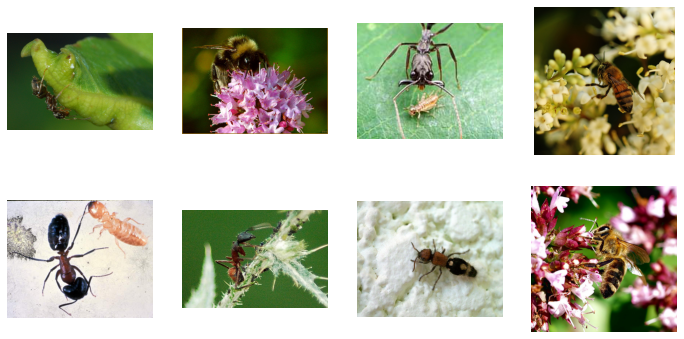

In [10]:
length = len(dataset)
indexes = np.random.choice(list(range(length)), size=8, replace=False)

visualise(dataset, indexes)

In [11]:
from torchvision import models

input_size = 224 # resnet учился на этом разрешении
model_ft = models.resnet18(pretrained=True)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
num_classes = 2
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# Учим только последний слой
# for param in model_ft.parameters():
#         param.requires_grad = False
        
# model_ft.fc = nn.Sequential(nn.Dropout(p=.7), nn.Linear(num_ftrs, num_classes))
# model_ft.fc.weight.requires_grad = True
# model_ft.fc.bias.requires_grad = True

In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2



In [15]:
train_transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.25, rotate_limit=45, p=0.5), # Случайные повороты/сдвиги/масштабирование
        A.HorizontalFlip(p=0.5),
        A.SmallestMaxSize(max_size=input_size), # Приводим меньшую сторону к конкретному размеру
        A.RandomCrop(height=input_size, width=input_size), # Делаем срез нужного нам размера в случайном месте
        A.RGBShift(r_shift_limit=0.5, g_shift_limit=0.5, b_shift_limit=0.5, p=0.5), # Смещаем цвет
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Нормализуем изображение яркость/ констраст
        ToTensorV2(),# Приводим к тензору
        
    ]
)

train_dataset = DataGenerator(train_filepaths, train_transform)



In [16]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=input_size),# Приводим меньшую сторону к конкретному размеру
        A.CenterCrop(height=input_size, width=input_size),# Делаем срез нужного нам размера в центре
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Нормализуем изображение яркость/ констраст
        ToTensorV2(),
    ]
)

val_dataset = DataGenerator(val_filepaths, val_transform)


In [17]:

image_datasets = {'train':train_dataset,
                  'val': val_dataset}
# Создадим загурзчики
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x],
                                                   batch_size=32,
                                                   shuffle=True,
                                                   num_workers=8) for x in ['train', 'val']}

# Ищем ГПУ
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [27]:
model_ft = models.resnet18(pretrained=True)
num_classes = 2
num_ftrs = model_ft.fc.in_features
for param in model_ft.parameters():
    param.requires_grad = False

model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft.fc = nn.Sequential(nn.Dropout(p=.5), nn.Linear(num_ftrs, num_classes))

In [28]:
for param in model_ft.layer4[1].parameters():
    param.requires_grad = True

In [29]:
# Send the model to GPU
model_ft = model_ft.to(device).float()


optimizer_ft = optim.Adam([param for param in model_ft.parameters() if param.requires_grad], lr=0.0001)

In [30]:

criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft,
                             dataloaders_dict, 
                             criterion,
                             optimizer_ft,
                             num_epochs=40)

Epoch 0/39
----------
train Loss: 0.8640 Acc: 0.5143
val Loss: 0.7007 Acc: 0.5425

Epoch 1/39
----------
train Loss: 0.5989 Acc: 0.6653
val Loss: 0.7219 Acc: 0.5425

Epoch 2/39
----------
train Loss: 0.5704 Acc: 0.7143
val Loss: 0.7045 Acc: 0.5425

Epoch 3/39
----------
train Loss: 0.5837 Acc: 0.7143
val Loss: 0.6916 Acc: 0.5425

Epoch 4/39
----------
train Loss: 0.4710 Acc: 0.7755
val Loss: 0.7048 Acc: 0.4967

Epoch 5/39
----------
train Loss: 0.5488 Acc: 0.7265
val Loss: 0.7392 Acc: 0.4902

Epoch 6/39
----------
train Loss: 0.5450 Acc: 0.7184
val Loss: 0.6865 Acc: 0.5229

Epoch 7/39
----------
train Loss: 0.4630 Acc: 0.7673
val Loss: 0.5935 Acc: 0.6797

Epoch 8/39
----------
train Loss: 0.5112 Acc: 0.7347
val Loss: 0.5437 Acc: 0.7255

Epoch 9/39
----------
train Loss: 0.5051 Acc: 0.7469
val Loss: 0.5204 Acc: 0.7255

Epoch 10/39
----------
train Loss: 0.4762 Acc: 0.7796
val Loss: 0.4852 Acc: 0.7908

Epoch 11/39
----------
train Loss: 0.4657 Acc: 0.7959
val Loss: 0.4680 Acc: 0.7974

Ep